In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from torch import optim
import math
import pypianoroll


# Customized Dataset

In [2]:

class customDataset2(data.Dataset):
    def __init__(self,folder,subfolders,trainingtype):
        self.folder = folder # this contains subfolders such as mozart
        self.subfolders = subfolders
        self.trainingtype = trainingtype # this is either Train, Val, or Test
        
        subfoldername = self.subfolders # get all the subfoler names such as chopin
        
        # extract desired datasets from each of the subfolders
        all_songs = []
        for foldername in  subfoldername:
            # this gives the path of desired folder: e.g..../Chopin/Train
            dataset_path_in_subfolder = os.path.join(folder,foldername,trainingtype)
            #print("desired folder ",dataset_path_in_subfolder)
            
            # this gives the song names in the desired folder: e.g. k21_op3.mid
            songs_in_dataset = os.listdir(dataset_path_in_subfolder)
            #print("songs: ", songs_in_dataset[:3])
            
            # combine the desired path with the song names: e.g. .../Chopin/Train/k21_op3.mid
            songs = map(lambda fname: os.path.join(dataset_path_in_subfolder,fname),
                                                    songs_in_dataset)
            songs = list(songs)
            #print("songs full: ",songs[:3])
            
            # append the songs to all_songs
            all_songs.extend(songs)
            #print("all songs: ", all_songs[:3])
        
        # hold a list of full file paths
        self.fnames_ful = all_songs
        print("Total samples: ",len(all_songs))
        #print(all_songs[:10])
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        ##input_seq = roll[:-1,:]
        input_seq = roll[:600,:] # length 500
        # we expect the model to predict the all elements
        ##output_seq = roll[-500:,:]
        ##output_seq = roll[-1000:,:]
        output_seq = roll[1:601,:] # length 500
        return (input_seq,output_seq)

# Dataloaders

In [3]:
folder = "Handcrafted Dataset - One Hot"
subfolders = ["Chopin","Beethoven","Mozart"]

length 3000 - total sample: 12587

length 2000 - total sample: 39798

In [4]:
trainingtype = "Train"

train_dataset = customDataset2(folder,subfolders,trainingtype)
train_dataloader = data.DataLoader(train_dataset,batch_size=64,shuffle=True)

Total samples:  39798


In [5]:
# check
X_train=next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([64, 600, 88])
torch.Size([64, 600, 88])


In [6]:
# validation set

trainingtype="Val"
#val_dataset = customDataset(path)
val_dataset = customDataset2(folder,subfolders,trainingtype)
# seperate val set into 5 sets because validate 40,000 every time is too much
#  now it would only validate on 8,000
set1 = list(range(0,len(val_dataset),2))
set2 = list(range(1,len(val_dataset),2))
#set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
#val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)""

size = 64
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
#val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,
               val_dataloader2]

Total samples:  6293


length 3000 - total: 2135


length 2000 - total: 6293

In [7]:
# check
X_val = next(iter(val_dataloader1))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([64, 600, 88])
torch.Size([64, 600, 88])


## visualization

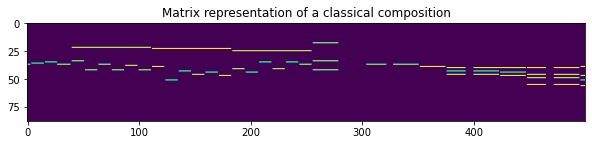

In [8]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a classical composition")
plt.imshow(X_train[0][4][:500].T)

# Training and validation Routine

In [9]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.float()
        
        output_seq = output_seq.transpose(0,1).contiguous()
        output_seq = output_seq.contiguous().view(-1)
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        loss = loss_fn(final,output_seq)
        val_loss += loss.item()
    
    print("The mean validation loss is %.6f" % (val_loss/steps))
    print()
    return val_loss/steps

In [10]:
def train(model,trainloader,valloaders,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            # try to fix error :"addmm_cuda" not implemented for 'Long'
            #  note: output_seq should stay long (int)
            input_seq = input_seq.float()
            #print("input shape: ",input_seq.shape)
            
            output_seq = output_seq.transpose(0,1).contiguous()
            #print("original output shape: ", output_seq.shape)
            output_seq = output_seq.contiguous().view(-1)
            
            #print("output shape: ", output_seq.shape)
            #print("largest output: ", torch.max(output_seq))
            
            # calculate grad and update
            optimizer.zero_grad()
            final,_ = model(input_seq)
            #print("prediction shape: ", final.shape)
            #print("largest prediction: ", torch.max(final.permute(1,0)[0]))
            # calculate loss and record loss
            # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            #final, output_seq = final.double(),output_seq.double()
            #print("final shape: ", final.shape) # (,2)
            #print("output shape: ", output_seq.shape)
            #print("final: ",final[:2,:])
            #print("output_seq:",output_seq[:2])
            loss = loss_fun(final, output_seq)
            #print("loss: ", loss)
            train_losses.append(loss.item())
            current_loss += loss.item()
            #print(current_loss)
            # update parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                print('EPOCHS : {}/{}'.format(e+1,ep),
                          'Loss : {:.6f}'.format(current_loss/print_every))

                current_loss = 0
                #which_val = random.randint(0,4)
                which_val = random.randint(0,1) # now I only have 2 val sets
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloaders[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "Handcrafted Dataset - One Hot Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
            model.train()
    return train_losses, val_losses

# Model

# Length 600


In [11]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 1024, 
                  num_class = 88, layers = 2):
        super(BaseLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        ###
        #self.final = nn.Linear(hidden_size,128)
        #self.final2 = nn.Linear(128,num_class)
        #self.relu = nn.ReLU()
        ###
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.1)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.1)(output_lnormed)
        

        
        # only take the final 1000
        #output_lnormed = output_lnormed[:,-1000:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        ###
        #final = self.relu(final)
        #final = nn.Dropout(0.5)(final)
        #final = self.final2(final)
        
        
        ###
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("original final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden

In [12]:
# experiment
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.stack((a,b),dim=1)
c

tensor([[1, 4],
        [2, 5],
        [3, 6]])

### 3 composers: Mozart, Chopin, Beethoven - BaseLSTM3com - gap 300

In [20]:
BaseLSTM3com = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(BaseLSTM3com.parameters(),lr=1e-4)

Batchsize = 64

In [21]:
train_loss, val_loss = train(BaseLSTM3com,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM3com")

  0%|          | 0/197 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.946582
The mean validation loss is 0.514326

EPOCHS : 1/1 Loss : 0.394370
The mean validation loss is 0.281572

EPOCHS : 1/1 Loss : 0.242034
The mean validation loss is 0.198186

EPOCHS : 1/1 Loss : 0.180362
The mean validation loss is 0.160735

EPOCHS : 1/1 Loss : 0.150928
The mean validation loss is 0.140709

EPOCHS : 1/1 Loss : 0.134902
The mean validation loss is 0.131139

EPOCHS : 1/1 Loss : 0.125805
The mean validation loss is 0.124569

EPOCHS : 1/1 Loss : 0.120392
The mean validation loss is 0.118896

EPOCHS : 1/1 Loss : 0.120852
The mean validation loss is 0.116593

EPOCHS : 1/1 Loss : 0.117648
The mean validation loss is 0.115170

EPOCHS : 1/1 Loss : 0.113383
The mean validation loss is 0.114327

EPOCHS : 1/1 Loss : 0.111149
The mean validation loss is 0.111746

EPOCHS : 1/1 Loss : 0.108611
The mean validation loss is 0.111540

EPOCHS : 1/1 Loss : 0.111678
The mean validation loss is 0.109051

EPOCHS : 1/1 Loss : 0.111974
The mean validation loss is 0.106

In [23]:
train_loss, val_loss = train(BaseLSTM3com,train_dataloader,val_dataloaders,4,40,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM3com")

  0%|          | 0/788 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.031052
The mean validation loss is 0.030716

EPOCHS : 1/4 Loss : 0.029718
The mean validation loss is 0.029587

EPOCHS : 1/4 Loss : 0.028434
The mean validation loss is 0.029210

EPOCHS : 1/4 Loss : 0.027787
The mean validation loss is 0.028047

EPOCHS : 1/4 Loss : 0.026981
The mean validation loss is 0.027633

EPOCHS : 1/4 Loss : 0.026316
The mean validation loss is 0.026200

EPOCHS : 1/4 Loss : 0.025761
The mean validation loss is 0.026021

EPOCHS : 1/4 Loss : 0.025879
The mean validation loss is 0.025102

EPOCHS : 1/4 Loss : 0.025092
The mean validation loss is 0.025262

EPOCHS : 1/4 Loss : 0.024813
The mean validation loss is 0.025540

EPOCHS : 2/4 Loss : 0.015576
The mean validation loss is 0.024845

EPOCHS : 2/4 Loss : 0.024374
The mean validation loss is 0.024826

EPOCHS : 2/4 Loss : 0.024454
The mean validation loss is 0.024735

EPOCHS : 2/4 Loss : 0.023807
The mean validation loss is 0.024265

EPOCHS : 2/4 Loss : 0.024169
The mean validation loss is 0.024

In [31]:
train_loss, val_loss = train(BaseLSTM3com,train_dataloader,val_dataloaders,4,40,
      loss_fun,optimizer,'cuda',3,grad_clip=1.0,mname="BaseLSTM3com")

  0%|          | 0/788 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.021587
The mean validation loss is 0.021551

EPOCHS : 1/4 Loss : 0.021757
The mean validation loss is 0.021371

EPOCHS : 1/4 Loss : 0.021133
The mean validation loss is 0.021528

EPOCHS : 1/4 Loss : 0.021121
The mean validation loss is 0.021481

EPOCHS : 1/4 Loss : 0.021345
The mean validation loss is 0.021967

EPOCHS : 1/4 Loss : 0.021582
The mean validation loss is 0.021987

EPOCHS : 1/4 Loss : 0.021054
The mean validation loss is 0.021999

EPOCHS : 1/4 Loss : 0.021332
The mean validation loss is 0.021333

EPOCHS : 1/4 Loss : 0.021332
The mean validation loss is 0.021932

EPOCHS : 1/4 Loss : 0.021179
The mean validation loss is 0.021262

EPOCHS : 2/4 Loss : 0.013260
The mean validation loss is 0.021376

EPOCHS : 2/4 Loss : 0.021121
The mean validation loss is 0.021261

EPOCHS : 2/4 Loss : 0.020837
The mean validation loss is 0.021223

EPOCHS : 2/4 Loss : 0.021680
The mean validation loss is 0.021257

EPOCHS : 2/4 Loss : 0.021466
The mean validation loss is 0.021

### BaseLSTM3com2 - gap 100
batchsize = 64

In [13]:
BaseLSTM3com2 = BaseLSTM(input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2).cuda()

#weights = torch.cuda.FloatTensor([1.0,2.0])
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(BaseLSTM3com2.parameters(),lr=1e-4)

In [14]:
train_loss, val_loss = train(BaseLSTM3com2,train_dataloader,val_dataloaders,1,40,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="BaseLSTM3com2")

  0%|          | 0/622 [00:00<?, ?it/s]

EPOCHS : 1/1 Loss : 0.485090
The mean validation loss is 0.178785

EPOCHS : 1/1 Loss : 0.143999
The mean validation loss is 0.124067

EPOCHS : 1/1 Loss : 0.118936
The mean validation loss is 0.113560

EPOCHS : 1/1 Loss : 0.109804
The mean validation loss is 0.107360

EPOCHS : 1/1 Loss : 0.103219
The mean validation loss is 0.099765

EPOCHS : 1/1 Loss : 0.095055
The mean validation loss is 0.087692

EPOCHS : 1/1 Loss : 0.080243
The mean validation loss is 0.071992

EPOCHS : 1/1 Loss : 0.066157
The mean validation loss is 0.058695

EPOCHS : 1/1 Loss : 0.053605
The mean validation loss is 0.048626

EPOCHS : 1/1 Loss : 0.045904
The mean validation loss is 0.041643

EPOCHS : 1/1 Loss : 0.040509
The mean validation loss is 0.037524

EPOCHS : 1/1 Loss : 0.036130
The mean validation loss is 0.034585

EPOCHS : 1/1 Loss : 0.032942
The mean validation loss is 0.032250

EPOCHS : 1/1 Loss : 0.031623
The mean validation loss is 0.030719

EPOCHS : 1/1 Loss : 0.030513
The mean validation loss is 0.029

In [15]:
train_loss, val_loss = train(BaseLSTM3com2,train_dataloader,val_dataloaders,4,40,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0,mname="BaseLSTM3com2")

  0%|          | 0/2488 [00:00<?, ?it/s]

EPOCHS : 1/4 Loss : 0.023449
The mean validation loss is 0.023176

EPOCHS : 1/4 Loss : 0.023273
The mean validation loss is 0.022872

EPOCHS : 1/4 Loss : 0.023168
The mean validation loss is 0.022773

EPOCHS : 1/4 Loss : 0.023096
The mean validation loss is 0.022918

EPOCHS : 1/4 Loss : 0.022997
The mean validation loss is 0.022618

EPOCHS : 1/4 Loss : 0.022894
The mean validation loss is 0.022559

EPOCHS : 1/4 Loss : 0.022936
The mean validation loss is 0.022488

EPOCHS : 1/4 Loss : 0.022991
The mean validation loss is 0.022550

EPOCHS : 1/4 Loss : 0.022856
The mean validation loss is 0.022360

EPOCHS : 1/4 Loss : 0.022799
The mean validation loss is 0.022561

EPOCHS : 2/4 Loss : 0.021879
The mean validation loss is 0.022568

EPOCHS : 2/4 Loss : 0.022529
The mean validation loss is 0.022505

EPOCHS : 2/4 Loss : 0.022644
The mean validation loss is 0.022435

EPOCHS : 2/4 Loss : 0.022539
The mean validation loss is 0.022185

EPOCHS : 2/4 Loss : 0.022551
The mean validation loss is 0.022

# Generate Music

In [20]:
# define a function to extract hidden state given the beginning of a piece of music
#  it should start from time step 0, extract the piano roll, take the first portion 
#   to generate hidden space and last prediction from the model
def get_hidden(model, path,len_input_seq=200,ln=200,tmp=1,start_position=0):
    # extract piano roll from the music and form one hot encoding
    multitrack = pypianoroll.read(path)
    multitrack.binarize()
    combined_track = multitrack.blend()
    # shrink the pitches and extract the part that we need
    track_len = len(combined_track[:,0]) 
    # if track_len is less than the track they want
    if (track_len < len_input_seq + start_position):
        if (track_len < len_input_seq):
            input_seq = combined_track[:,21:109] # take the entire trach
        else:
            input_seq = combined_track[start_position:,21:109] 
    else:
        end_position = start_position + len_input_seq - 1
        input_seq = combined_track[start_position:end_position,21:109]
    
    # input sequence must be a tensor
    input_seq = torch.tensor(input_seq,dtype=torch.float)
    
    # add batch dimension
    input_seq = torch.unsqueeze(input_seq,0)
    
    op, hidden = model(input_seq) # note hidden state don't stack
    
    # only take the last observations of each
    output = op[-88:]
    probs = nn.functional.softmax(output.div(tmp), dim=1)
    output = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
    output = output.float()
 
    # hidden size (2,2,200,512), should go with (2,2,1,512)
    h,c = hidden
    h = h[:,-1:,:]
    c = c[:,-1:,:]
    hidden = (h,c)
    
    return generate_music(model,output,hidden,ln,tmp)

# define a function to generate music based on the hidden state of the music
def generate_music(model, start, hidden, ln=200, tmp=1):
    seq_ip_cur = start
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = hidden

    for i in range(ln):

        # input sequence is predicted outputs
        op, hd = model(seq_ip_cur, hd) # output is a vector of 88
        #print("output: ",op)
        
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        #print("probabilities: ",probs)
        
        # update current sequence to the previous prediction
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # the model accept input as tensor of floats
        seq_ip_cur = seq_ip_cur.float()
        #print("updated sequence: ", seq_ip_cur.data.squeeze(1))

        # append outputs
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

def generate_sample(model,model_val,run,musicname="mz_330_1.mid",len_input_seq=200,
                    ln=200,tmp=1,model_name="LSTM_Chopin",start_position=0):
    weights_folder = "Handcrafted Dataset - One Hot Weights/"
    
    # this is for simple version
    #LSTM = model(input_size=88,embed_size=512,hidden_size=512,num_class=88).cpu() 
    
    LSTM = model(88,512,512,88,2).cpu() 
    weights = model_name+"-run-"+str(run)+"-val_loss-"+model_val+ ".pth"
    weights_path = os.path.join(weights_folder,weights)
    LSTM.load_state_dict(torch.load(weights_path))
    

    musicpath = "Handcrafted Dataset - Generated Music/input/Classical/" + musicname
    LSTM.eval()
    seq = get_hidden(LSTM,musicpath,len_input_seq,ln,tmp,start_position)
    
    plt.figure(figsize=(10,7))
    plt.imshow(seq.T)
    
    outputpath = 'Handcrafted Dataset - Generated Music/'+model_name+'/run'+str(run)+'-'+model_val+'-'+musicname
    return seq, outputpath

### too much - BaseLSTM3com model - gap 300

Handcrafted Dataset - Generated Music/BaseLSTM3com/run3-BEST-mz_330_1.mid


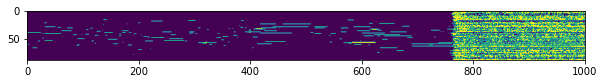

In [22]:
model = BaseLSTM
model_val = "BEST"
run = 3
seq,path=generate_sample(model,model_val,run,musicname="mz_330_1.mid",
            len_input_seq=2000,ln=1000,tmp=1,model_name="BaseLSTM3com",start_position=0)
print(path)

In [23]:
F.midiwrite(path, seq, dtm=0.1)

### BaseLSTM3com2 - gap 100

Handcrafted Dataset - Generated Music/BaseLSTM3com2/run3-BEST-mz_330_1.mid


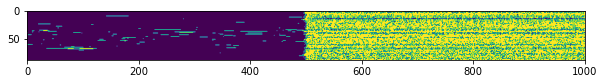

In [29]:
model = BaseLSTM
model_val = "BEST"
run = 3
seq,path=generate_sample(model,model_val,run,musicname="mz_330_1.mid",
            len_input_seq=2000,ln=1000,tmp=1,model_name="BaseLSTM3com2",start_position=0)
print(path)

In [27]:
F.midiwrite(path, seq, dtm=0.1)